## Features Explanation:
The following describes the columns present in the data.
* CustomerID -- Unique identifier of the customers
* Gender -- Whether the customer is a male or a female
* SeniorCitizen -- Whether a customer is a senior citizen or not
* Partner -- Whether the customer has a partner or not (Yes, No)
* Dependents -- Whether the customer has dependents or not (Yes, No)
* Tenure -- Number of months the customer has stayed with the company
* Phone Service -- Whether the customer has a phone service or not (Yes, No)
* MultipleLines -- Whether the customer has multiple lines or not
* InternetService -- Customer's internet service provider (DSL, Fiber Optic, No)
* OnlineSecurity -- Whether the customer has online security or not (Yes, No, No Internet)
* OnlineBackup -- Whether the customer has online backup or not (Yes, No, No Internet)
* DeviceProtection -- Whether the customer has device protection or not (Yes, No, No internet service)
* TechSupport -- Whether the customer has tech support or not (Yes, No, No internet)
* StreamingTV -- Whether the customer has streaming TV or not (Yes, No, No internet service)
* StreamingMovies -- Whether the customer has streaming movies or not (Yes, No, No Internet service)
* Contract -- The contract term of the customer (Month-to-Month, One year, Two year)
* PaperlessBilling -- Whether the customer has paperless billing or not (Yes, No)
* Payment Method -- The customer's payment method (Electronic check, mailed check, Bank transfer(automatic), Credit card(automatic))
* MonthlyCharges -- The amount charged to the customer monthly
* TotalCharges -- The total amount charged to the customer
* Churn -- Whether the customer churned or not (Yes or No)    

# QUESTIONS:
1) Does age factor affect the customers churn rate?
2) Among customers who have churned, which type of contract is most prevalent?
3) Which gender has the higest rate of churning
4) What is the percentage breakdown of customers who have left the company? (Pie chart)
5) Is there a correlation between total charges and the type of contract? (Bar chart)
6) How does the churn rate vary based on the duration of customer subscription (tenure)?

# 1) DATA UNDERSTANDING

### Libraries Importation

In [681]:
import pandas as pd
from dotenv import dotenv_values
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import pyodbc
from scipy.stats import chi2_contingency
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,f1_score,classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression


from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import balanced_accuracy_score,roc_auc_score,roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif



from skopt import BayesSearchCV
import pickle
import joblib
 

import warnings

warnings.filterwarnings('ignore')



### Database Connection

In [579]:
login = dotenv_values('.env')

In [580]:
PASS = login.get('password')
USER = login.get('user')
SERVER = login.get('server')
DATABASE = login.get('dbname')

In [581]:
connection = f"DRIVER={{ODBC Driver 18 for SQL Server}};SERVER={SERVER};DATABASE={DATABASE};UID={USER};PWD={PASS};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"


In [582]:
conn = pyodbc.connect(connection)

In [583]:
query = '''SELECT *
        FROM dbo.LP2_Telco_churn_first_3000'''


In [584]:
df = pd.read_sql_query(query,conn)

df.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True


In [585]:
# Testing dataset
df2 = pd.read_excel('Telco-churn-second-2000.xlsx')
df2.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55


In [586]:
# Evaluation dataset
df3 = pd.read_csv('LP2_Telco-churn-last-2000.csv')
df3.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No


In [587]:
df3.shape

(2043, 21)

In [588]:
df.shape

(3000, 21)

### Concate the Data(df & df3)

In [589]:
data= pd.concat([df,df3],ignore_index=True,verify_integrity=True,axis=0)
data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True


## EDA

In [590]:
data.shape

(5043, 21)

In [591]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


In [592]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5043.0,0.162403,0.368857,0.0,0.000,0.000000,0.000000,1.000000
tenure,5043.0,32.576641,24.529807,0.0,9.000,29.000000,56.000000,72.000000
MonthlyCharges,5043.0,65.090214,30.068133,18.4,35.775,70.550003,90.050003,118.650002


### * To check duplicates

In [593]:
data.duplicated().sum()

0

### * To check missing data

In [594]:
data.isna().sum().sum()

4181

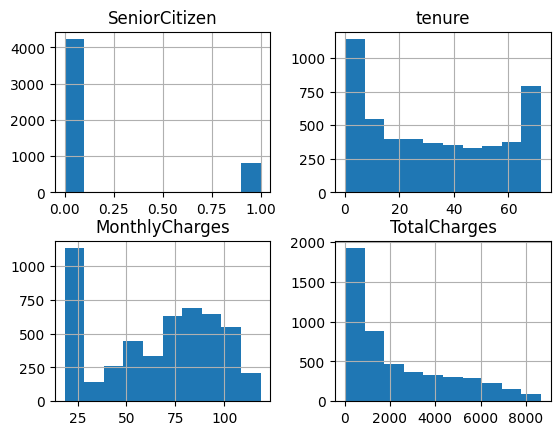

In [595]:
data['TotalCharges']= pd.to_numeric(data['TotalCharges'], errors='coerce')
data.hist();

In [687]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5042.0,0.162436,0.368886,0.000000,0.000000,0.000000,0.000000,1.000000
tenure,5042.0,32.568822,24.525954,0.000000,9.000000,29.000000,56.000000,72.000000
MonthlyCharges,5042.0,65.081376,30.064564,18.400000,35.762500,70.550003,90.050002,118.650002
TotalCharges,5034.0,2300.954758,2268.346402,18.799999,417.662498,1401.000000,3860.599976,8670.100000


### INSIGHTS:

Tenure:

*From the data above, we are able to tell that the maximum tenure of service by the customers is 72 months.

*We can also deduce that the average tenure for most customers is around 32 months as indicated the mean value of the tenure

Monthly Charges:

*From the table above the average monthly charge by a customer is given as at around $65 , whereas the highest monthly charge is around $ 118 .
*The minimum paying customer pays around $18 while majority of the customers pay around $90.

Total Charges:

*The monthly charges data indicated that the customers pay an average of $2300 monthly while the lowest monthly charge is around $18.

*The data also suggests that the highest paid monthly charge was around $8670 whereas a majority of the customers pay around $1400 and above

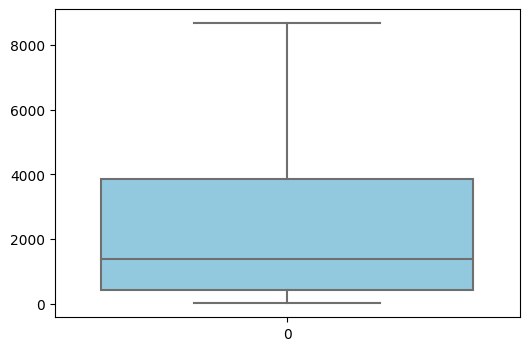

In [596]:
data_box = df[['SeniorCitizen','tenure','TotalCharges','MonthlyCharges']]
plt.figure(figsize=(6,4))
sns.boxplot(data=data['TotalCharges'],color='skyblue');

In [597]:
corr = data.corr(numeric_only=True)
corr

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
SeniorCitizen,1.000000,0.004597,0.221780,0.095212
tenure,0.004597,1.000000,0.240645,0.826264
MonthlyCharges,0.221780,0.240645,1.000000,0.647007
TotalCharges,0.095212,0.826264,0.647007,1.000000


In [598]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5043.0,0.162403,0.368857,0.000000,0.000000,0.000000,0.000000,1.000000
tenure,5043.0,32.576641,24.529807,0.000000,9.000000,29.000000,56.000000,72.000000
MonthlyCharges,5043.0,65.090214,30.068133,18.400000,35.775000,70.550003,90.050003,118.650002
TotalCharges,5035.0,2302.062861,2269.483576,18.799999,417.675003,1401.150024,3862.000000,8670.100000


In [599]:
data.describe(include='object')

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,5043,5043,5043,5043,5043,4774,5043,4392,4392,4392,4392,4392,4392,5043,5043,5043,5042
unique,5043,2,4,4,4,5,3,5,5,5,5,5,5,3,4,4,4
top,7590-VHVEG,Male,False,False,True,False,Fiber optic,False,False,False,False,False,True,Month-to-month,True,Electronic check,False
freq,1,2559,1538,2070,2731,1437,2248,1478,1320,1296,1476,1190,1199,2744,1776,1700,2219


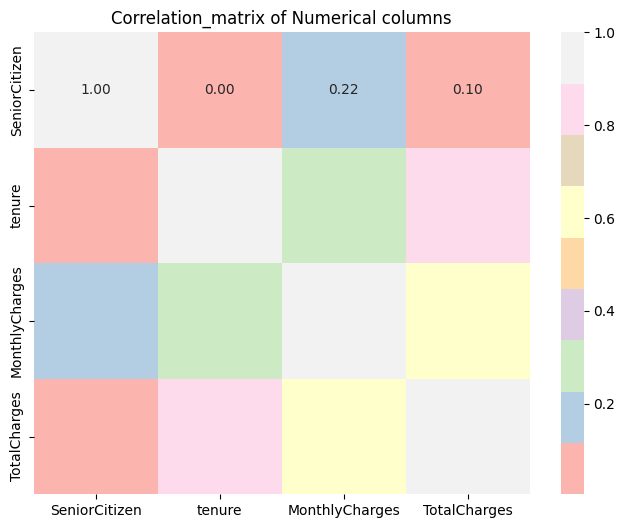

In [691]:

numerical_columns = data.select_dtypes(include=[np.number])
corr = numerical_columns.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='Pastel1', fmt=".2f")
plt.title('Correlation_matrix of Numerical columns')
plt.show()
 

### Different payment methods

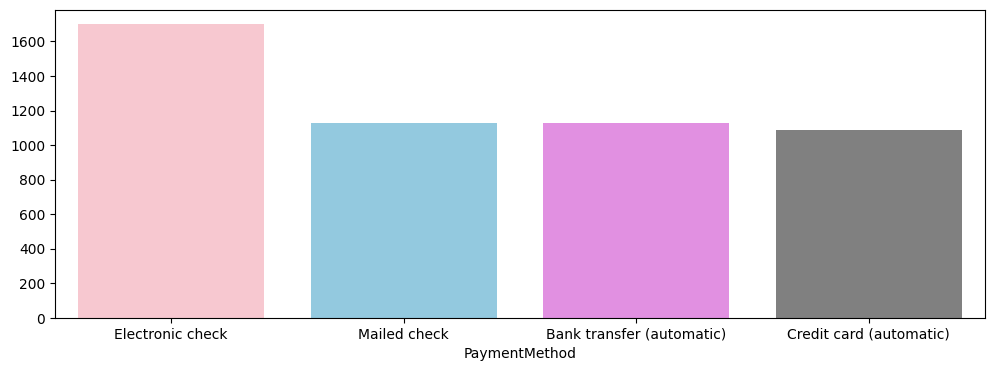

In [678]:


plt.figure(figsize=(12, 4))
ax = sns.countplot(x="PaymentMethod", data=data, palette=['pink', 'skyblue', 'violet', 'grey'])
ax.set(ylabel=None)
plt.show()


### Different Internet service providers

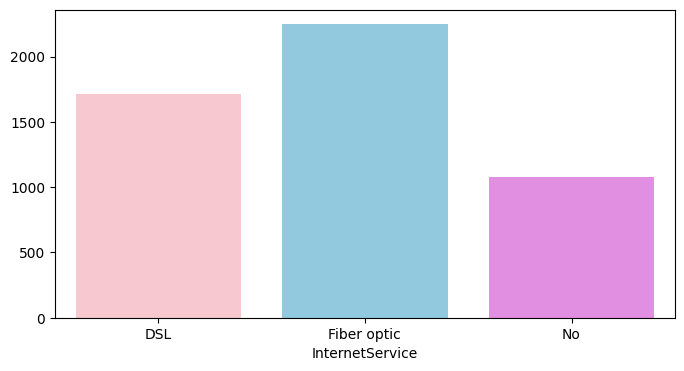

In [679]:
plt.figure(figsize=(8,4))
ax = sns.countplot(x="InternetService",data= data,palette=['pink', 'skyblue', 'violet'])
ax.set(ylabel=None)
plt.show()

### Multivariate analysis

<Figure size 1000x800 with 0 Axes>

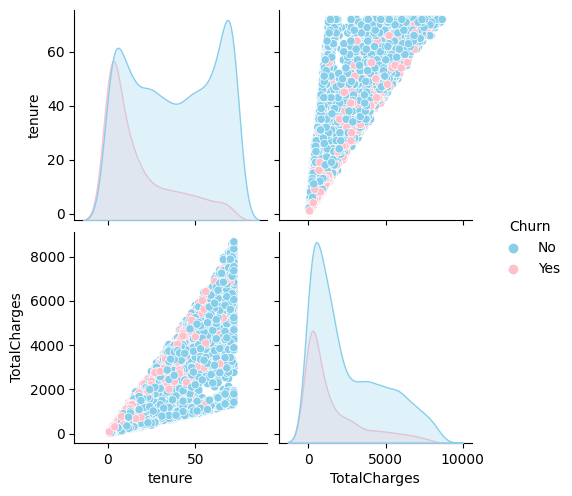

In [692]:
mv_data = data[["tenure",'TotalCharges','Churn']]
plt.figure(figsize=(10, 8))
sns.pairplot(mv_data, palette={'Yes':'pink', 'No':'skyblue'}, hue = 'Churn')
plt.show()

## 2) ANSWER THE BUSINESS QUESTIONS:

### 1) Does age factor affect the customers churn rate?

In [602]:
data.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.50,False


In [603]:
data['SeniorCitizen'].unique()

array([0, 1], dtype=int64)

In [604]:
data['Churn'].replace({False:'No',True:'Yes'}, inplace= True)

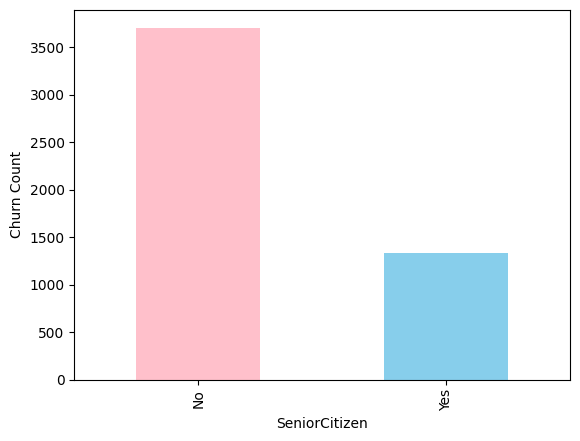

In [605]:

(
    data.groupby('Churn')['SeniorCitizen']
    .count().plot(kind='bar',ylabel='Churn Count',xlabel='SeniorCitizen',color=('pink','skyblue'))
    
);

INSIGHT: The above data suggests that customers who are younger tend to churn more as opposed to older customers. Therefore indeed age contributes to the churn rate.

### 2) Among customers who have churned, which type of contract is most prevalent?

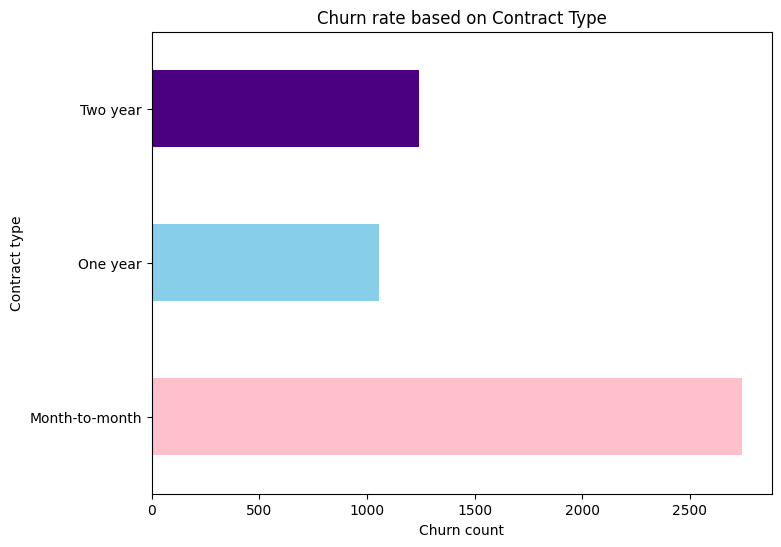

In [606]:
contract_churn = (
    data.groupby('Contract')['Churn'].count()
)

plt.figure(figsize=(8,6))
contract_churn.plot(kind='barh', color=['pink','skyblue','indigo'])
plt.title('Churn rate based on Contract Type')
plt.ylabel('Contract type')
plt.xlabel('Churn count');

INSIGHT: The graph above shows that customer with monthly contract are the highest churned as opposed to the ones with 2 year contract. This may suggest that the longterm customers eventually get to understand the company and the services and products offered hence less churn.

### 3) Which gender has the higest rate of churning

In [607]:
data['Churn'].unique()

array(['No', 'Yes', None], dtype=object)

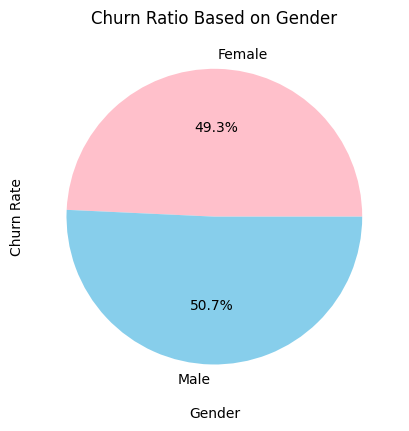

In [608]:
#data['Churn'] = data['Churn'].replace({False:'No',True:'Yes'})
gender = data.groupby('gender')['Churn'].count()
gender.plot(kind='pie', colors=['pink','skyblue'], autopct='%1.1f%%')
plt.xlabel('Gender')
plt.ylabel('Churn Rate')
plt.title('Churn Ratio Based on Gender')
plt.show();

INSIGHT: The above graph shows that gender doesn't necessarily contribute to the churn rate, as its seen that the difference between the genders is 1.4% hence the conclusion.

### 4) What is the percentage breakdown of customers who have left the company? (Pie chart)

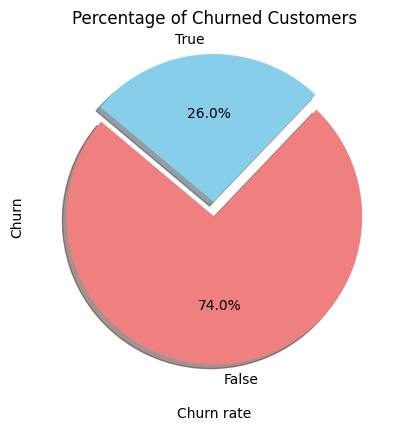

In [609]:
left = df.groupby('Churn')['Churn'].count()
explode = (0, 0.1)
left.plot(kind='pie', colors=['lightcoral','skyblue'], explode=explode, shadow=True, startangle=140,autopct='%1.1f%%')
plt.xlabel('Churn rate')
#plt.ylabel('Churn Rate')
plt.title('Percentage of Churned Customers')
plt.show();

INSIGHT: From the graph above, it shows the percentage of churn customers is 26% whereas the not churned is 74%.

### 5) Is there a correlation between total charges and the type of contract? (Bar chart)

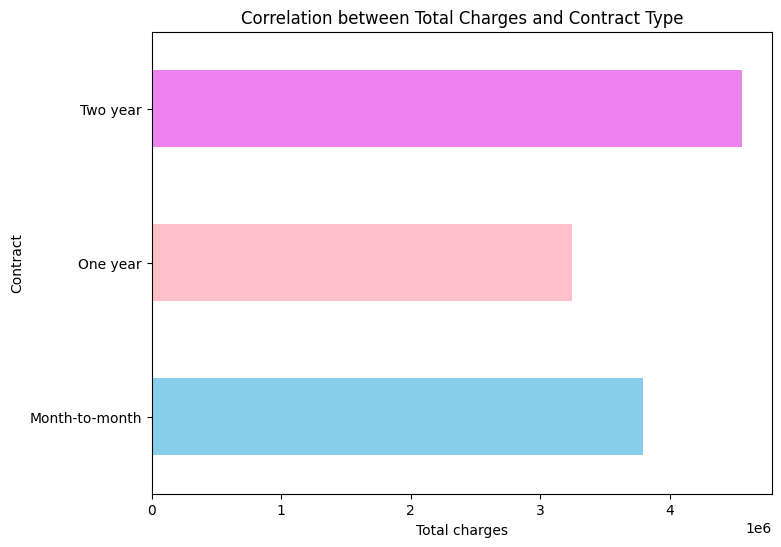

In [610]:
corr_charges_contract = data.groupby('Contract')['TotalCharges'].sum()

plt.figure(figsize=(8,6))
corr_charges_contract.plot(kind='barh',color=['skyblue','pink','violet'])
plt.xlabel('Total charges')
plt.title('Correlation between Total Charges and Contract Type')
plt.show()

INSIGHT: From the data above, we see that customers with 2 year contract have the highest total charges, and this can probably be argued that it may be due to the length of stay with the company. The 2 year contract is followed by the monthly contract customers and lastly the 1 year contract plans.

### 6) How does the churn rate vary based on the duration of customer subscription (tenure)?

In [611]:
data['tenure'].max()

72

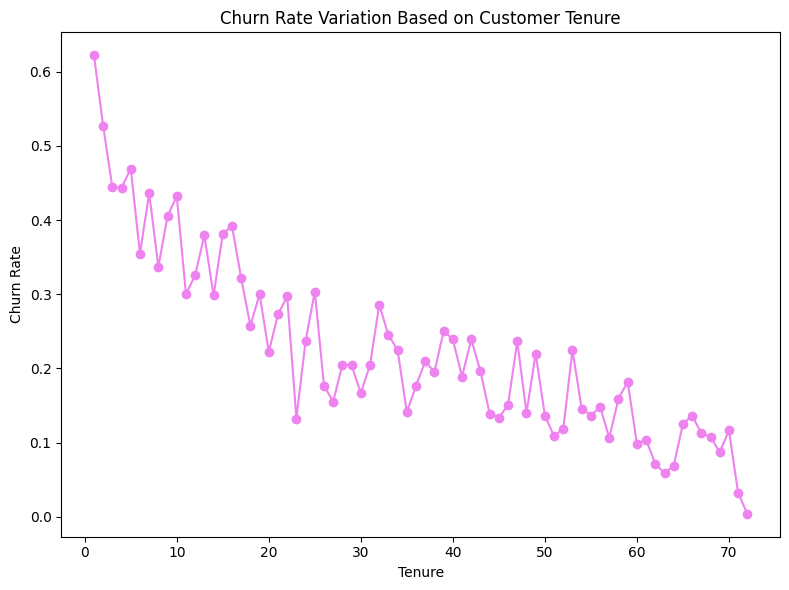

In [612]:
#bin= [0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59, 60-64, 65-69, 70-74]
Sub = data.groupby('tenure')['Churn'].value_counts(normalize=True).unstack()


#tenure_churn = conc.groupby('tenure')['Churn'].value_counts(normalize=True).unstack()
 
# Plotting the line chart
plt.figure(figsize=(8,6))
Sub['Yes'].plot(kind='line', marker='o', color='violet')
plt.title('Churn Rate Variation Based on Customer Tenure')
plt.xlabel('Tenure')
plt.ylabel('Churn Rate')
plt.tight_layout()
plt.show()

INSIGHT: The data above indicates that customers who have been with the company longer rarely churn while it shows high churn rate for those of short tenure.

In [613]:
data['PhoneService']

0       False
1        True
2        True
3       False
4        True
        ...  
5038      Yes
5039      Yes
5040       No
5041      Yes
5042      Yes
Name: PhoneService, Length: 5043, dtype: object

### Hypothesis Testing

In [686]:
#create a contingency table, extract relevant columns (Contract and PaymentMethod)
conti_table = pd.crosstab(data['gender'], data['Churn'])

#chi-squared test
chi2, p, dof, expected = chi2_contingency(conti_table)

# Output the results
print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")

# significance level
alpha = 0.05

# Check the p-value against the significance level
if p < alpha:
    print("Reject the null hypothesis. Gender affects the churn rate.")
else:
    print("Fail to reject the null hypothesis. Gender indeed affects the customer churn rate.")


Chi-squared value: 0.021628520637713346
P-value: 0.8830796247912641
Fail to reject the null hypothesis. Gender indeed affects the customer churn rate.


##  3) DATA PREPARATION

In [615]:
# Check for nulls

data.isna().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 1
dtype: int64

In [616]:
data[data['Churn'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2988,6295-OSINB,Male,0,True,False,72,True,True,Fiber optic,True,...,True,False,True,True,Two year,True,Electronic check,109.650002,7880.25,None


In [617]:
data = data.drop(index=2988)

## 4) FEATURE ENGINEERING

### Split data into X ,y(Independent, dependent)

In [618]:
X = data.drop(columns=['Churn','customerID'])
y = data['Churn']

In [619]:
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,True,False,1,False,None,DSL,False,True,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000
1,Male,0,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000
2,Male,0,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002
3,Male,0,False,False,45,False,None,DSL,True,False,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000
4,Female,0,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994


In [620]:
y.head()

0     No
1     No
2    Yes
3     No
4    Yes
Name: Churn, dtype: object

In [621]:
y.unique()

array(['No', 'Yes'], dtype=object)

In [622]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5042 entries, 0 to 5042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5042 non-null   object 
 1   SeniorCitizen     5042 non-null   int64  
 2   Partner           5042 non-null   object 
 3   Dependents        5042 non-null   object 
 4   tenure            5042 non-null   int64  
 5   PhoneService      5042 non-null   object 
 6   MultipleLines     4773 non-null   object 
 7   InternetService   5042 non-null   object 
 8   OnlineSecurity    4391 non-null   object 
 9   OnlineBackup      4391 non-null   object 
 10  DeviceProtection  4391 non-null   object 
 11  TechSupport       4391 non-null   object 
 12  StreamingTV       4391 non-null   object 
 13  StreamingMovies   4391 non-null   object 
 14  Contract          5042 non-null   object 
 15  PaperlessBilling  5042 non-null   object 
 16  PaymentMethod     5042 non-null   object 
 17  

In [623]:
y.isna().sum()

0

In [624]:
X.isna().sum()

gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
dtype: int64

### Create Pipeline

In [625]:
# Select Numerical caolumns

numeric_col = X.select_dtypes(include='number').columns

#numeric_col= pd.to_numeric(numeric_col)
numeric_col

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

In [626]:
# Select categorical columns

categorical_col = X.select_dtypes(include='object').columns
categorical_col

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [627]:
# To check the unique values in the columns

for cols in categorical_col:
    unique = data[cols].unique()
    print('='*70)
    print(f'{cols}:{unique}')

gender:['Female' 'Male']
Partner:[True False 'No' 'Yes']
Dependents:[False True 'No' 'Yes']
PhoneService:[False True 'Yes' 'No']
MultipleLines:[None False True 'No' 'No phone service' 'Yes']
InternetService:['DSL' 'Fiber optic' 'No']
OnlineSecurity:[False True None 'No' 'Yes' 'No internet service']
OnlineBackup:[True False None 'No' 'Yes' 'No internet service']
DeviceProtection:[False True None 'No' 'Yes' 'No internet service']
TechSupport:[False True None 'Yes' 'No' 'No internet service']
StreamingTV:[False True None 'No' 'Yes' 'No internet service']
StreamingMovies:[False True None 'No' 'Yes' 'No internet service']
Contract:['Month-to-month' 'One year' 'Two year']
PaperlessBilling:[True False 'Yes' 'No']
PaymentMethod:['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [628]:
# To Standardise the values

bool_string = {True : 'Yes', False : 'No',
               'Yes' : 'Yes', 'No' : 'No'}



In [629]:
X.loc[:,categorical_col] = X[categorical_col].apply(lambda x: x.replace(bool_string))
categorical_col = X.select_dtypes(include=['bool','object']).columns
categorical_col

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [630]:
X.shape

(5042, 19)

In [631]:
#X=X.fillna('NaN')

### To create pipelines

In [632]:
numeric_pipe = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='mean')),
    ('Scaler',RobustScaler())
])
#numeric_pipe = Pipeline(steps=[
   # ('Imputer', SimpleImputer(strategy='mean')),
   # ('log_transformation', FunctionTransformer(np.log1p)),
    #('scaler', StandardScaler())
#])

categoric_pipe = Pipeline(steps=[
    ('cat_imputer',SimpleImputer(missing_values=np.nan,strategy='constant',fill_value='No')),
    ('encode',OneHotEncoder(handle_unknown='ignore'))
])

transformer = ColumnTransformer([
    ('num_pipe',numeric_pipe,numeric_col),
    ('cat_pipe',categoric_pipe,categorical_col)
])

### Transformed Categorical columns

In [633]:
X_transform = pd.DataFrame(transformer.fit_transform(X),columns=transformer.get_feature_names_out())
X_transform

,num_pipe__SeniorCitizen,num_pipe__tenure,num_pipe__MonthlyCharges,num_pipe__TotalCharges,cat_pipe__gender_Female,cat_pipe__gender_Male,cat_pipe__Partner_No,cat_pipe__Partner_Yes,cat_pipe__Dependents_No,cat_pipe__Dependents_Yes,...,cat_pipe__StreamingMovies_None,cat_pipe__Contract_Month-to-month,cat_pipe__Contract_One year,cat_pipe__Contract_Two year,cat_pipe__PaperlessBilling_No,cat_pipe__PaperlessBilling_Yes,cat_pipe__PaymentMethod_Bank transfer (automatic),cat_pipe__PaymentMethod_Credit card (automatic),cat_pipe__PaymentMethod_Electronic check,cat_pipe__PaymentMethod_Mailed check
0,0.0,-0.595745,-0.749712,-0.400042,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.106383,-0.250518,0.140689,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,-0.574468,-0.307622,-0.377275,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.340426,-0.520378,0.126514,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0.0,-0.574468,0.002763,-0.364626,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5037,0.0,-0.106383,0.262491,0.170057,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5038,0.0,0.914894,0.601428,1.732193,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5039,0.0,-0.382979,-0.754317,-0.307984,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5040,1.0,-0.531915,0.070919,-0.319571,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [634]:
y.unique()

array(['No', 'Yes'], dtype=object)

In [635]:

selection = SelectKBest(mutual_info_classif, k=30)

### Split data into Train and Test

In [636]:
X_train,X_eval,y_train,y_eval = train_test_split(X,y, train_size=0.8, random_state=42)

### Label Encode

In [637]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_eval_encoded = le.fit_transform(y_eval)


In [638]:
X_train.shape

(4033, 19)

In [639]:
X_eval.shape

(1009, 19)

In [640]:
y_train.value_counts()

Churn
No     2947
Yes    1086
Name: count, dtype: int64

### Machine Learning Pipeline

 Model Training and ROC

In [641]:

dtc = Pipeline([
    ('preprocessor',transformer),
    ('classifier',DecisionTreeClassifier(random_state=42))
])


In [642]:
dtc.fit(X_train,y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('Scaler',
                                                                   RobustScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='No',
                                                                                 strategy='constant')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [643]:
random_forest_pipe = Pipeline([
    ('preprocessor',transformer),
    ('classifier',RandomForestClassifier(random_state=42))
])
random_forest_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('Scaler',
                                                                   RobustScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='No',
                                                                                 strategy='constant')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [644]:
Gradient_pipe = Pipeline([
    ('preprocessor',transformer),
    ('classifier',GradientBoostingClassifier(random_state=1))
])

Gradient_pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('Scaler',
                                                                   RobustScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='No',
                                                                                 strategy='constant')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('classifier', GradientBoostingClassifier(random_state=1))])

In [645]:
Naives =Pipeline([
    ('preprocessor',transformer),
    ('classifier',GaussianNB())
])

#Naives.fit(X_train,y_train)


Naives.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('Scaler',
                                                                   RobustScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='No',
                                                                                 strategy='constant')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('classifier', GaussianNB())])

### ROC For The Trained Models

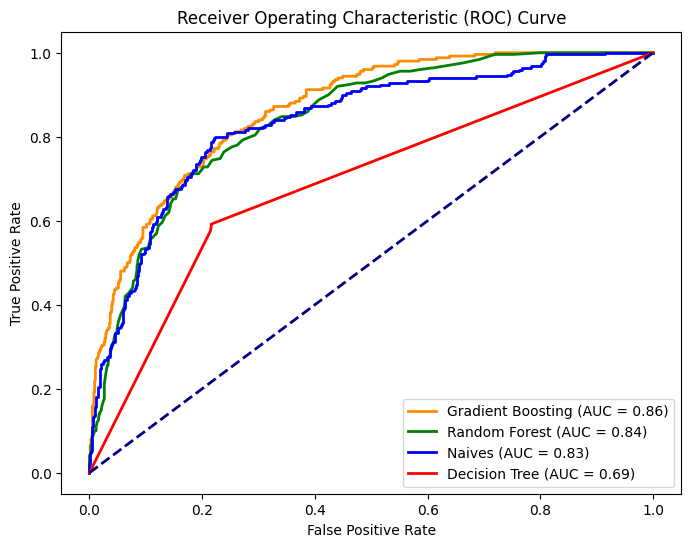

In [646]:
y_scores_Gradient = Gradient_pipe.predict_proba(X_eval)[:, 1]
y_scores_RandomForest = random_forest_pipe.predict_proba(X_eval)[:, 1]
y_scores_Naives = Naives.predict_proba(X_eval)[:, 1]
y_scores_Decisiontree = dtc.predict_proba(X_eval)[:, 1]

# Calculate ROC curve for each model
fpr_Gradient, tpr_Gradient, _ = roc_curve(y_eval_encoded, y_scores_Gradient)
fpr_RandomForest, tpr_RandomForest, _ = roc_curve(y_eval_encoded, y_scores_RandomForest)
fpr_Naives, tpr_Naives, _ = roc_curve(y_eval_encoded, y_scores_Naives)
fpr_Decisiontree, tpr_Decisiontree, _ = roc_curve(y_eval_encoded, y_scores_Decisiontree)

# Calculate the area under the curve (AUC) for each model
roc_auc_Gradient = auc(fpr_Gradient, tpr_Gradient)
roc_auc_RandomForest = auc(fpr_RandomForest, tpr_RandomForest)
roc_auc_Naives = auc(fpr_Naives, tpr_Naives)
roc_auc_Decisiontree = auc(fpr_Decisiontree, tpr_Decisiontree)

# Plot ROC curves for each model on the same graph
plt.figure(figsize=(8, 6))
plt.plot(fpr_Gradient, tpr_Gradient, color='darkorange', lw=2, label=f'Gradient Boosting (AUC = {roc_auc_Gradient:.2f})')
plt.plot(fpr_RandomForest, tpr_RandomForest, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_RandomForest:.2f})')
plt.plot(fpr_Naives, tpr_Naives, color='blue', lw=2, label=f'Naives (AUC = {roc_auc_Naives:.2f})')
plt.plot(fpr_Decisiontree, tpr_Decisiontree, color='red', lw=2, label=f'Decision Tree (AUC = {roc_auc_Decisiontree:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### Model Evaluation using Confusion metrics

In [647]:
from sklearn import metrics

pred = Gradient_pipe.predict(X_eval)

confusion_mtrx = metrics.confusion_matrix(y_eval,pred)
confusion_mtrx

array([[676,  83],
       [ 99, 151]], dtype=int64)

* Diagnol values represent accurate predictions while non-diagonal values are inaccurate predictions. From our output, 703 and 119 represent accurate predictions while 56 and 131 represent inaccurate predictions. Which means the total of accurate predictions is 822 values out of 1009 test values. We can conclude that our machine did very well.

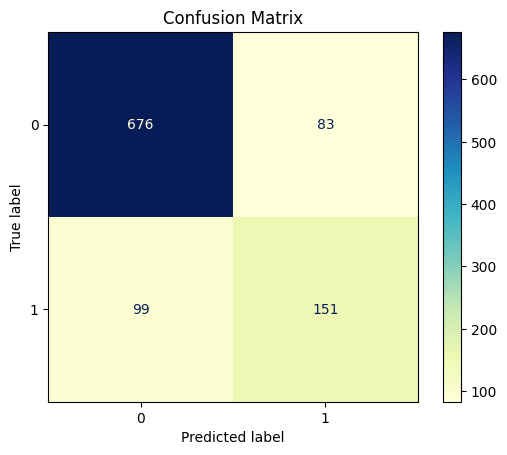

In [648]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_mtrx, display_labels=None)  # You can set display_labels if you have specific class labels
disp.plot(cmap='YlGnBu', values_format='d')
plt.title('Confusion Matrix')
plt.show()

## Machine Learning Unbalanced Data

In [649]:
models =[
    ('Naives', GaussianNB()),
    ('Random_Forest', RandomForestClassifier(random_state=42)),
    ('Decision_Tree', DecisionTreeClassifier(random_state=42)),
    ('Gradient_Boosting', GradientBoostingClassifier(random_state=42)),
    ('SVC', SVC(random_state=42))
]

target_names =['Not_Churn','Churn']
#models = [Decision_tree,random_forest_pipe,Gradient_pipe,Naives]

In [650]:
# Generating report for the unbalanced Data

for model_name,classifier in models:

    pipeline = Pipeline(steps=[
        ('preprocessor', transformer),
        ('classifier', classifier)
    ])

    pipeline.fit(X_train,y_train_encoded)

    y_pred = pipeline.predict(X_eval)

    print(f'Report for {model_name}')
    print(classification_report(y_eval_encoded,y_pred,target_names=target_names))
    print('='*70)

Report for Naives
              precision    recall  f1-score   support

   Not_Churn       0.94      0.54      0.69       759
       Churn       0.39      0.90      0.55       250

    accuracy                           0.63      1009
   macro avg       0.67      0.72      0.62      1009
weighted avg       0.81      0.63      0.65      1009

Report for Random_Forest
              precision    recall  f1-score   support

   Not_Churn       0.86      0.88      0.87       759
       Churn       0.61      0.57      0.59       250

    accuracy                           0.80      1009
   macro avg       0.74      0.72      0.73      1009
weighted avg       0.80      0.80      0.80      1009

Report for Decision_Tree
              precision    recall  f1-score   support

   Not_Churn       0.85      0.78      0.82       759
       Churn       0.47      0.59      0.52       250

    accuracy                           0.74      1009
   macro avg       0.66      0.69      0.67      1009
weight

 * Based on the generated report, and the trained models, the SVC model seems to be better perfoming than the other models. The SVC has an accuracy score of 82% and F1 score of 89% for not  churn and 62 for churn. The SVC model also boosts a recall score of 91% ,which means the true positives predicted is at 91%

In [651]:
unbalanced_metrics = pd.DataFrame(columns=['model_name','Accuracy','Precision','recall','f1_score'])

for model_name,classifier in models:

    pipeline = Pipeline(steps=[
        ('preprocessor', transformer),
        ('classifier', classifier)
    ])

    pipeline.fit(X_train,y_train_encoded)

    y_pred = pipeline.predict(X_eval)

   

    metrics= classification_report(y_eval_encoded,y_pred,target_names=target_names,output_dict=True)

    accuracy = metrics['accuracy']
    precision = metrics['weighted avg']['precision']
    recall = metrics['weighted avg']['recall']
    f1_score =metrics ['weighted avg']['f1-score']

    unbalanced_metrics.loc[len(unbalanced_metrics)] = [model_name, accuracy,precision,recall,f1_score]

In [652]:
unbalanced_metrics

,model_name,Accuracy,Precision,recall,f1_score
0,Naives,0.630327,0.808016,0.630327,0.652788
1,Random_Forest,0.803766,0.799325,0.803766,0.801252
2,Decision_Tree,0.735382,0.758341,0.735382,0.744229
3,Gradient_Boosting,0.819623,0.816024,0.819623,0.817583
4,SVC,0.823588,0.816552,0.823588,0.818788


In [653]:
X_train.shape

(4033, 19)

In [654]:
y_train.value_counts()

Churn
No     2947
Yes    1086
Name: count, dtype: int64

### BALANCE THE DATASET

Balancing the dataset using the Over_sampling

In [655]:
smote = SMOTE(random_state=42)


from imblearn.over_sampling import RandomOverSampler, SMOTE
sampler = RandomOverSampler(random_state=42)

X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train_encoded)

In [656]:
pd.DataFrame(y_train_resampled).value_counts()

0    2947
1    2947
Name: count, dtype: int64

In [657]:
len(y_train_resampled)

5894

In [658]:
len(X_train_resampled)

5894

### Modeling and Evaluating Balanced Data

In [659]:
balanced = pd.DataFrame(columns=['model_name','Accuracy','Precision','recall','f1_score'])


for model_name,classifier in models:


   pipe = Pipeline([
    ('preprocessor', transformer),
    ('classifier', classifier)
])
    
   pipe.fit(X_train_resampled,y_train_resampled) 

   y_pred = pipe.predict(X_eval)

   metrics = classification_report(y_eval_encoded,y_pred, output_dict=True)

   accuracy = metrics['accuracy']
   precision = metrics['weighted avg']['precision']
   recall = metrics['weighted avg']['recall']
   f1_score = metrics['weighted avg']['f1-score']

   balanced.loc[len(balanced)] = [model_name, accuracy,precision,recall,f1_score]
   





In [660]:
balanced

,model_name,Accuracy,Precision,recall,f1_score
0,Naives,0.625372,0.806692,0.625372,0.647814
1,Random_Forest,0.784936,0.795911,0.784936,0.789433
2,Decision_Tree,0.731417,0.745151,0.731417,0.737315
3,Gradient_Boosting,0.749257,0.819499,0.749257,0.765075
4,SVC,0.749257,0.822781,0.749257,0.765291


* After balancing the dataset, training and modelling it, the Random Forest Classifier seems to be the better perfoming with an F1 score of 80% and an 80% precision score. The Random Forest is followed by SVC and gradient Boosting Classifier.

## 5) HYPEPARAMETER TUNING

In [661]:
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV

In [662]:
from sklearn.svm import SVC

In [663]:
model = RandomForestClassifier()

In [664]:
pipeline = Pipeline([
    ('preprocessor',transformer),  # Example preprocessing step
    ('classifier', RandomForestClassifier(random_state=42))  # Provide an instance
])

# Define the parameter grid
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
}

# Create GridSearchCV with the instantiated pipeline
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1'
)

# Fit the GridSearchCV on your data
grid_search.fit(X_train, y_train_encoded)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num_pipe',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('Scaler',
                                                                                          RobustScaler())]),
                                                                         Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                                        ('cat_pipe',
                                                                         Pipeline(steps=[('cat_imputer',
                                                                                          SimpleImputer(fill_value='No',
                                                                                                        strategy='constant'...
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [50, 100, 200]},
             scoring='f1')

best_parameters = grid_search.best_params_
best_parameters

In [665]:
best_estimator = grid_search.best_estimator_


test_accuracy = best_estimator.score(X_eval, y_eval_encoded)
print("Test Accuracy", test_accuracy)

Test Accuracy 0.8126858275520317


In [666]:
params = grid_search.best_params_

### Retrain the Model

In [667]:
random_forest_pipe.set_params(**params)
random_forest_pipe.fit(X_train, y_train_encoded)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_pipe',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('Scaler',
                                                                   RobustScaler())]),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')),
                                                 ('cat_pipe',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='No',
                                                                                 strategy='constant')),
                                                                  ('encode',
                                                                   OneHotEncoder(h...ore'))]),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_split=5,
                                        random_state=42))])

### Model Persistence

In [669]:
with open("Random_Model.pkl", 'rb') as file:
    loaded_model = pickle.load(file)


### Evaluate Model with test dataset

In [670]:
test = pd.read_excel('Telco-churn-second-2000.xlsx')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


### Loading test data

In [ ]:


path = r'E:\AZUBI CAREER ACCELERATOR\Data Analytics\PROJECTS\Project 2\LP2-Classification-Project\Telco-churn-second-2000.xlsx'
new_data = pd.read_excel(path)

if hasattr(loaded_model, 'named_steps'):
    # Apply the same preprocessing steps
    new_data_preprocessed = loaded_model.named_steps['preprocessor'].transform(new_data)
else:
    # No preprocessing step in the pipeline
    new_data_preprocessed = new_data

# Make predictions using the loaded logistic regression pipeline
y_pred_proba = loaded_model.predict_proba(new_data_preprocessed)[:, 1]

### To Save Concat Data to CSV

In [ ]:
data.to_csv('Telco_data.csv')